In [1]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import wandb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModelForSequenceClassification, AutoTokenizer, TrainingArguments, Trainer
from datasets import Dataset, DatasetDict, load_metric
from sklearn.preprocessing import LabelEncoder
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import re
import nltk
import contractions

In [13]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [14]:
df = pd.read_csv("Data/Suicide_Detection.csv",index_col=0)
df.reset_index(drop=True, inplace=True)
df = df.dropna()

In [15]:
# check the number of empty rows.
print(df['text'].apply(lambda x: x == '').sum())
# remove the empty rows
df = df[df['text'].apply(lambda x: len(x.split())!=0)]

0


In [16]:
df.head()

,text,class
0,Ex Wife Threatening SuicideRecently I left my ...,suicide
1,Am I weird I don't get affected by compliments...,non-suicide
2,Finally 2020 is almost over... So I can never ...,non-suicide
3,i need helpjust help me im crying so hard,suicide
4,"I’m so lostHello, my name is Adam (16) and I’v...",suicide


<Axes: >

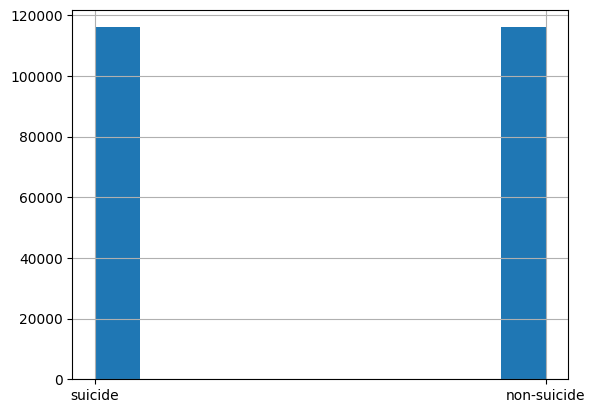

In [6]:
df['class'].hist()

### Preprocessing the dataset.

In [17]:
# Text normalization and cleaning
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
stop_words.remove("not")

def clean_text(text):
    try:
        text = contractions.fix(text)  # remove contractions
    except:
        pass
    text = text.lower()  # convert text to lowercase
    text = re.sub(r'\d+', '', text)  # remove numbers
    text = re.sub(r'https?://\S+|www\.\S+|www\S+', '', text)  # Remove URLs
    text = re.sub(r'[^\x00-\x7F]+', '', text)  # Remove accented characters
    text = re.sub(r'[\U00010000-\U0010ffff]', '', text)  # Remove emojis
    text = re.sub(r'(\w)\1{2,}', r'\1', text)  # Remove consecutive repeated characters if repeated 3 or more times
    text = re.sub(r'\W', ' ', text)  # remove special characters
    text = re.sub(r'\s+', ' ', text)  # remove extra white spaces
    word_tokens = word_tokenize(text)  # tokenize text
    filtered_text = [lemmatizer.lemmatize(w) for w in word_tokens if not w in stop_words]  # remove stopwords and lemmatize
    return ' '.join(filtered_text)

df['text'] = df['text'].apply(clean_text)
# rename the column class to label
df.rename(columns={'class': 'label'}, inplace=True)

# encoder = LabelEncoder()
# df['class_label'] = encoder.fit_transform(df['class'])

In [18]:
df.head()
df.to_csv('Data/Suicide_Detection_Cleaned.csv', index=False)

In [19]:
dataset = Dataset.from_pandas(df)
dataset= dataset.remove_columns("__index_level_0__")
dataset = dataset.train_test_split(test_size=0.2)
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 185659
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 46415
    })
})


In [20]:

dataset.push_to_hub("phr_suicide_prediction_dataset")

Pushing dataset shards to the dataset hub:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/186 [00:00<?, ?ba/s]

Pushing dataset shards to the dataset hub:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/47 [00:00<?, ?ba/s]

#### EDA on cleaned dataset about words and their frequency.

In [19]:
from collections import Counter
df2 = pd.read_csv("Data/Suicide_Detection_Cleaned.csv")
df2['text'] = df2['text'].astype(str)
df2['tokens'] = df2['text'].apply(nltk.word_tokenize)
word_counts = Counter(word for tokens in df2['tokens'] for word in tokens)
print(word_counts)

Counter({'not': 678615, 'like': 185111, 'want': 174406, 'know': 148252, 'feel': 136760, 'life': 129366, 'would': 124693, 'get': 120722, 'time': 105756, 'people': 97146, 'one': 95114, 'friend': 92660, 'even': 91148, 'year': 89238, 'going': 85579, 'really': 84395, 'day': 81804, 'thing': 81003, 'think': 75845, 'go': 74282, 'never': 67075, 'make': 66125, 'much': 60539, 'help': 59946, 'could': 58843, 'filler': 54682, 'way': 50951, 'thought': 50186, 'got': 49599, 'school': 47364, 'good': 46953, 'someone': 46072, 'fucking': 45829, 'anything': 45660, 'anymore': 45228, 'need': 44792, 'back': 44134, 'see': 43819, 'say': 43534, 'still': 43067, 'something': 41987, 'love': 41550, 'everything': 41503, 'family': 41383, 'end': 40798, 'nothing': 40492, 'die': 40406, 'fuck': 40375, 'better': 40329, 'always': 40287, 'right': 39252, 'every': 39248, 'anyone': 39129, 'talk': 39002, 'live': 37991, 'kill': 37700, 'work': 37300, 'hate': 36889, 'suicide': 36881, 'care': 35759, 'take': 35445, 'ever': 34844, 'fee